In [1]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar100
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
#create train and test splits
(trainX, trainY), (testX, testY) = cifar100.load_data()

trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

trainX_mean = np.mean(trainX, axis=0)
testX_mean = np.mean(testX, axis=0)
trainX -= trainX_mean
testX -= testX_mean

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

169009152/169001437 [==============================] - 4s 0us/step


In [0]:
BS = 128
datagen = ImageDataGenerator(validation_split=0.3)
train_gen = datagen.flow(trainX, trainY, batch_size=BS)
test_gen = datagen.flow(testX, testY, batch_size=BS)

In [0]:
#defining residual block and simple conv block
def res_block(filters, x):
  inp = x
  x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
  x = keras.layers.add([inp, x])
  return x

def conv_block(filters, x):
  x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
  return x

In [7]:
#creating model
from keras import layers
input_shape = trainX[0].shape
inputs = Input(shape=input_shape)

x = Conv2D(32, (7,7), strides=(2,2), activation='relu')(inputs)
x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

for i in range(3):
  x = res_block(32, x)
x = conv_block(64, x)

for i in range(3):
  x = res_block(64, x)
x = conv_block(128, x)

for i in range(5):
  x = res_block(128, x)
x = conv_block(256, x)

for i in range(2):
  x = res_block(256, x)

x = layers.GlobalAveragePooling2D()(x)
outputs = Dense(100, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs, outputs)

In [8]:
#compiling model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 13, 13, 32)   4736        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 6, 6, 32)     0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 6, 6, 32)     9248        max_pooling2d_2[0][0]            
__________________________________________________________________________________________

In [10]:
#training
import math
EPOCHS = 120
train_size = len(trainX)
test_size = len(testX)
train_steps = math.ceil(train_size/BS)
valid_steps = math.ceil(test_size/BS)
H = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                        epochs=EPOCHS, validation_data=(testX, testY))
model.save('resnetmodel.h5')

Epoch 1/120
391/391 [==============================] - 16s 41ms/step - loss: 4.4799 - acc: 0.0182 - val_loss: 4.4612 - val_acc: 0.0193
Epoch 2/120
391/391 [==============================] - 16s 41ms/step - loss: 4.4485 - acc: 0.0211 - val_loss: 4.4419 - val_acc: 0.0224
Epoch 3/120
391/391 [==============================] - 16s 41ms/step - loss: 4.4228 - acc: 0.0236 - val_loss: 4.4041 - val_acc: 0.0253
Epoch 4/120
391/391 [==============================] - 16s 42ms/step - loss: 4.3859 - acc: 0.0275 - val_loss: 4.3936 - val_acc: 0.0261
Epoch 5/120
391/391 [==============================] - 17s 42ms/step - loss: 4.2898 - acc: 0.0298 - val_loss: 4.2122 - val_acc: 0.0312
Epoch 6/120
391/391 [==============================] - 17s 43ms/step - loss: 4.1948 - acc: 0.0352 - val_loss: 4.2212 - val_acc: 0.0339
Epoch 7/120
391/391 [==============================] - 17s 43ms/step - loss: 4.1390 - acc: 0.0417 - val_loss: 4.3211 - val_acc: 0.0309
Epoch 8/120
391/391 [==============================] - 

In [11]:
'''EVALUATING THE MODEL'''
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 183us/step
Test loss: 4.987698561096192
Test accuracy: 0.404


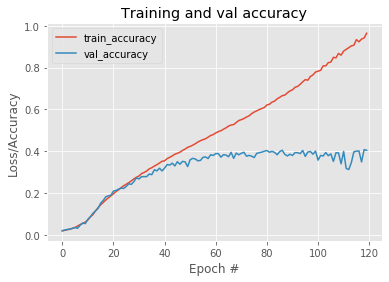

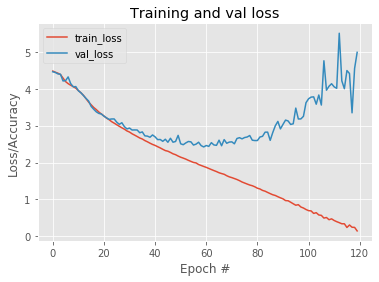

In [12]:
'''PLOT OF ACCURACY AND LOSS WRT EPOCHS'''
from matplotlib import pyplot as plt
N = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H.history['acc'], label='train_accuracy')
plt.plot(N, H.history['val_acc'], label='val_accuracy')
plt.title('Training and val accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.title('Training and val loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [14]:
'''CONFUSION MATRIX'''
from sklearn.metrics import confusion_matrix
predictions = model.predict(testX, batch_size=BS)
print(confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1)))

[[63  1  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0 28 ...  1  4  0]
 ...
 [ 0  0  1 ... 39  2  0]
 [ 0  1  4 ...  0 12  2]
 [ 0  0  0 ...  0  0 37]]


In [15]:
from sklearn.metrics import classification_report
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       100
           1       0.51      0.52      0.52       100
           2       0.33      0.28      0.30       100
           3       0.21      0.16      0.18       100
           4       0.27      0.33      0.30       100
           5       0.42      0.35      0.38       100
           6       0.43      0.32      0.37       100
           7       0.36      0.48      0.41       100
           8       0.44      0.40      0.42       100
           9       0.53      0.54      0.53       100
          10       0.21      0.14      0.17       100
          11       0.27      0.26      0.26       100
          12       0.31      0.44      0.37       100
          13       0.28      0.35      0.31       100
          14       0.28      0.25      0.26       100
          15       0.38      0.31      0.34       100
          16       0.34      0.39      0.36       100
          17       0.66    